In [1]:
import torch
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show,output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook,export_png
from bokeh.layouts import column,gridplot
import numpy as np
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
import pandas as pd
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

In [2]:
train=pd.read_excel(r"../data/chem_train.xlsx")
test=pd.read_excel(r"../data/chem_test.xlsx")

In [3]:
train.corrected_week<53

0        True
1        True
2       False
3        True
4        True
        ...  
1276     True
1277     True
1278     True
1279     True
1280     True
Name: corrected_week, Length: 1281, dtype: bool

In [4]:
train_predict=train.copy()
train=train.loc[(train.corrected_week>0)&(train.corrected_week<53),:]
test_predict=test.copy()
test=test.loc[(test.corrected_week>0)&(test.corrected_week<53),:]

In [5]:
gpr_acetone=torch.load("../models/acetone_seasonality",weights_only=False,map_location='cuda')
gpr_form=torch.load("../models/form_seasonality",weights_only=False,map_location='cuda')
gpr_acetald=torch.load("../models/acetald_seasonality",weights_only=False,map_location='cuda')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
linmod=torch.linspace(0,52,800).to(device)
pm25_model,pm25_model_std=gpr_form(linmod,full_cov=True)

linmod_np=linmod.cpu().detach().numpy()
pm25_model_np,pm25_model_std_np=pm25_model.cpu().detach().numpy().copy(),pm25_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1 = pm25_model_np - pm25_model_std_np
upper1 = pm25_model_np + pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1],index=["corrected_week","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

In [8]:

bc_model,bc_model_std=gpr_acetald(linmod, full_cov=True)
bc_model_np,bc_model_std_np=bc_model.cpu().detach().numpy().copy(),bc_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_bc = bc_model_np - bc_model_std_np
upper1_bc = bc_model_np + bc_model_std_np
data1_bc=pd.DataFrame([linmod_np,lower1_bc,upper1_bc],index=["corrected_week","lower_bc","upper_bc"]).T
data1_bc = ColumnDataSource(data1_bc.reset_index())

In [9]:

ac_model,ac_model_std=gpr_acetone(linmod, full_cov=True)
ac_model_np,ac_model_std_np=ac_model.cpu().detach().numpy().copy(),ac_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_ac = ac_model_np - ac_model_std_np
upper1_ac = ac_model_np + ac_model_std_np
data1_ac=pd.DataFrame([linmod_np,lower1_ac,upper1_ac],index=["corrected_week","lower_ac","upper_ac"]).T
data1_ac = ColumnDataSource(data1_ac.reset_index())

In [10]:
def roll_week(data,resolution,week,particle):
    mean=[]
    std=[]
    x=np.linspace(0,53,resolution,endpoint=True)
    sort=data.sort_values("corrected_week")
    list_std=[particle+"_std" for particle in particle]
    for i in x:
        mean.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].mean())
        std.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].std())
    mean_1,std_1=pd.DataFrame(mean,index=x),pd.DataFrame(std,index=x)
    std_1.columns=std_1.columns+"_std"
    data=pd.concat([mean_1,std_1],axis=1)
    return data.set_index(x)

In [11]:
resolution=500
averange_week=2
x=np.linspace(0,53,resolution,endpoint=True)
mean=roll_week(train_predict,resolution,averange_week,["formaldehyd","acetald","acetone"])
mean_test=roll_week(test_predict,resolution,averange_week,["formaldehyd","acetald","acetone"])
formald=gpr_form(torch.tensor(x).float().to(device))[0].cpu().detach().numpy()
acetald=gpr_acetald(torch.tensor(x).float().to(device))[0].cpu().detach().numpy()
acetone=gpr_acetone(torch.tensor(x).float().to(device))[0].cpu().detach().numpy()

In [12]:
lower1_std = mean.formaldehyd - mean.formaldehyd_std
upper1_std = mean.formaldehyd + mean.formaldehyd_std
lower1_bc_std  = mean.acetald - mean.acetald_std
upper1_bc_std  = mean.acetald + mean.acetald_std
lower1_ac_std  = mean.acetone - mean.acetone_std
upper1_ac_std  = mean.acetone + mean.acetone_std
mean["lower1_std_pm"]=lower1_std
mean["upper1_std_pm"]=upper1_std
mean["lower1_std_bc"]=lower1_bc_std
mean["upper1_std_bc"]=upper1_bc_std
mean["lower1_std_ac"]=lower1_ac_std
mean["upper1_std_ac"]=upper1_ac_std
mean=mean.dropna()
mean1 = ColumnDataSource(mean.reset_index())

In [13]:
form_test=r2_score(mean_test.formaldehyd,formald)
acetald_test=r2_score(mean_test.acetald,acetald)
acetone_test=r2_score(mean_test.acetone,acetone)

In [14]:
form1=r2_score(mean.formaldehyd,formald)
acetald1=r2_score(mean.acetald,acetald)
acetone1=r2_score(mean.acetone,acetone)

In [15]:
np.sqrt(((mean_test-mean)**2).mean(axis=0))

acetald            1.466679
acetald_std        2.978384
acetone            2.627803
acetone_std        4.842935
formaldehyd        2.268772
formaldehyd_std    3.605303
lower1_std_ac           NaN
lower1_std_bc           NaN
lower1_std_pm           NaN
upper1_std_ac           NaN
upper1_std_bc           NaN
upper1_std_pm           NaN
dtype: float64

In [16]:
mean

,formaldehyd,acetald,acetone,formaldehyd_std,acetald_std,acetone_std,lower1_std_pm,upper1_std_pm,lower1_std_bc,upper1_std_bc,lower1_std_ac,upper1_std_ac
0.000000,20.127105,9.286078,12.003207,14.720859,11.514843,7.907486,5.406246,34.847965,-2.228765,20.800921,4.095721,19.910694
0.106212,20.093613,9.448880,12.417221,15.000195,11.692104,7.742692,5.093418,35.093808,-2.243224,21.140984,4.674528,20.159913
0.212425,20.520995,9.448293,12.012310,15.449149,12.100877,7.674452,5.071846,35.970144,-2.652585,21.549170,4.337858,19.686761
0.318637,20.260202,9.211065,11.869957,14.971696,11.688087,7.607366,5.288507,35.231898,-2.477022,20.899151,4.262591,19.477324
0.424850,19.869770,9.446167,12.442629,14.510817,11.757052,8.109620,5.358952,34.380587,-2.310885,21.203219,4.333009,20.552249
...,...,...,...,...,...,...,...,...,...,...,...,...
52.575150,20.260202,9.211065,11.869957,14.971696,11.688087,7.607366,5.288507,35.231898,-2.477022,20.899151,4.262591,19.477324
52.681363,19.869770,9.446167,12.442629,14.510817,11.757052,8.109620,5.358952,34.380587,-2.310885,21.203219,4.333009,20.552249
52.787575,19.869770,9.446167,12.442629,14.510817,11.757052,8.109620,5.358952,34.380587,-2.310885,21.203219,4.333009,20.552249
52.893788,19.869770,9.446167,12.442629,14.510817,11.757052,8.109620,5.358952,34.380587,-2.310885,21.203219,4.333009,20.552249


In [17]:
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

Loading BokehJS ...

In [18]:
p = figure(x_range=(0, 53),y_range=(0, 50),tools=TOOLS);
p.title.text = r"Formaldehyd seasonality";
p.xgrid.grid_line_color=None;
p.ygrid.grid_line_alpha=0.5;
p.line(mean.index, mean.formaldehyd, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(form1,2)));
p.line(mean_test.index, mean_test.formaldehyd, line_width=3,color="orange",legend_label="Test roll mean R2 "+str(round(form_test,2)));
p.line(linmod_np, pm25_model_np, line_width=3,color="red",legend_label="Gaussion model");
p.scatter(train.corrected_week, y=train.formaldehyd, color="blue", marker="dot", size=20, alpha=0.4,legend_label="raw points");
band = Band(base="index", lower="lower1_std_pm", upper="upper1_std_pm",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
band1 = Band(base="corrected_week", lower="lower", upper="upper",source=data1,fill_alpha=0.5, fill_color="blue", line_color="black");
p.yaxis.axis_label_orientation  = 0
p.add_layout(band);
p.add_layout(band1);
p.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p.yaxis.axis_label = r'$$\frac{\mu g}{m^3} $$';
p1 = figure(x_range=(0, 53),y_range=(0, 30),tools=TOOLS);
p1.title.text = r"Acetald seasonality";
p1.xgrid.grid_line_color=None;
p1.ygrid.grid_line_alpha=0.5;
p1.line(mean_test.index, mean_test.acetald, line_width=3,color="orange",legend_label="Test roll mean R2 "+str(round(acetald_test,2)));

p1.line(mean.index, mean.acetald, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(acetald1,2)));
p1.line(linmod_np, bc_model_np, line_width=3,color="red",legend_label="Gaussion model");
p1.scatter(train.corrected_week, y=train.acetald, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band2 = Band(base="corrected_week", lower="lower_bc", upper="upper_bc",source=data1_bc, fill_color="blue", line_color="black",fill_alpha=0.5);
band3 = Band(base="index", lower="lower1_std_bc", upper="upper1_std_bc",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
p1.add_layout(band3);
p1.add_layout(band2);
p1.yaxis.axis_label_orientation  = 0
p1.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p1.yaxis.axis_label = r'$$ \frac{\mu g}{m^3} $$';
p1.legend.title_text_font_size = "16px";
p.legend.title_text_font_size = "16px";
p.xaxis.axis_label_text_font_size = "14px";
p.yaxis.axis_label_text_font_size = "14px";
p1.xaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_style = "bold";
p1.xaxis.axis_label_text_font_style = "bold";
p.yaxis.axis_label_text_font_style = "bold";
p.xaxis.axis_label_text_font_style = "bold";
p2 = figure(x_range=(0, 53),y_range=(0, 40),tools=TOOLS);
p2.title.text = r"Acetone seasonality";
p2.xgrid.grid_line_color=None;
p2.ygrid.grid_line_alpha=0.5;
p2.line(mean.index, mean.acetone, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(acetone1,2)));
p2.line(mean_test.index, mean_test.acetone, line_width=3,color="orange",legend_label="Test roll mean R2 "+str(round(acetone_test,2)));

p2.line(linmod_np, ac_model_np, line_width=3,color="red",legend_label="Gaussion model");
p2.scatter(train.corrected_week, y=train.acetone, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band4 = Band(base="corrected_week", lower="lower_ac", upper="upper_ac",source=data1_ac, fill_color="blue", line_color="black",fill_alpha=0.5);
band5 = Band(base="index", lower="lower1_std_ac", upper="upper1_std_ac",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
p2.add_layout(band4);
p2.add_layout(band5);
p2.yaxis.axis_label_orientation  = 0
p2.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p2.yaxis.axis_label = r'$$ \frac{\mu g}{m^3} $$';
p2.legend.title_text_font_size = "16px";
p2.legend.title_text_font_size = "16px";
p2.xaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_size = "14px";
p2.xaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_size = "14px";
p2.yaxis.axis_label_text_font_style = "bold";
p2.xaxis.axis_label_text_font_style = "bold";
p2.yaxis.axis_label_text_font_style = "bold";
p2.xaxis.axis_label_text_font_style = "bold";
grid =  gridplot([[p, p1,p2]], width=500, height=500);

show(column(grid));

In [22]:
pyro_data_acetald=az.from_json("Arviz_stats/acetald_seasonality.json")

FileNotFoundError: [Errno 2] No such file or directory: 'Arviz_stats/acetald_seasonality.json'

In [23]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_acetald,backend='bokeh')

NameError: name 'pyro_data_acetald' is not defined

In [24]:
az.plot_pair(pyro_data_acetald,kind='kde',divergences=True,textsize=18)


NameError: name 'pyro_data_acetald' is not defined

In [19]:
pyro_data_acetone=az.from_json("Arviz_stats/mcmc_acetone_seasonality.json")

In [21]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_acetone,backend='bokeh')

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

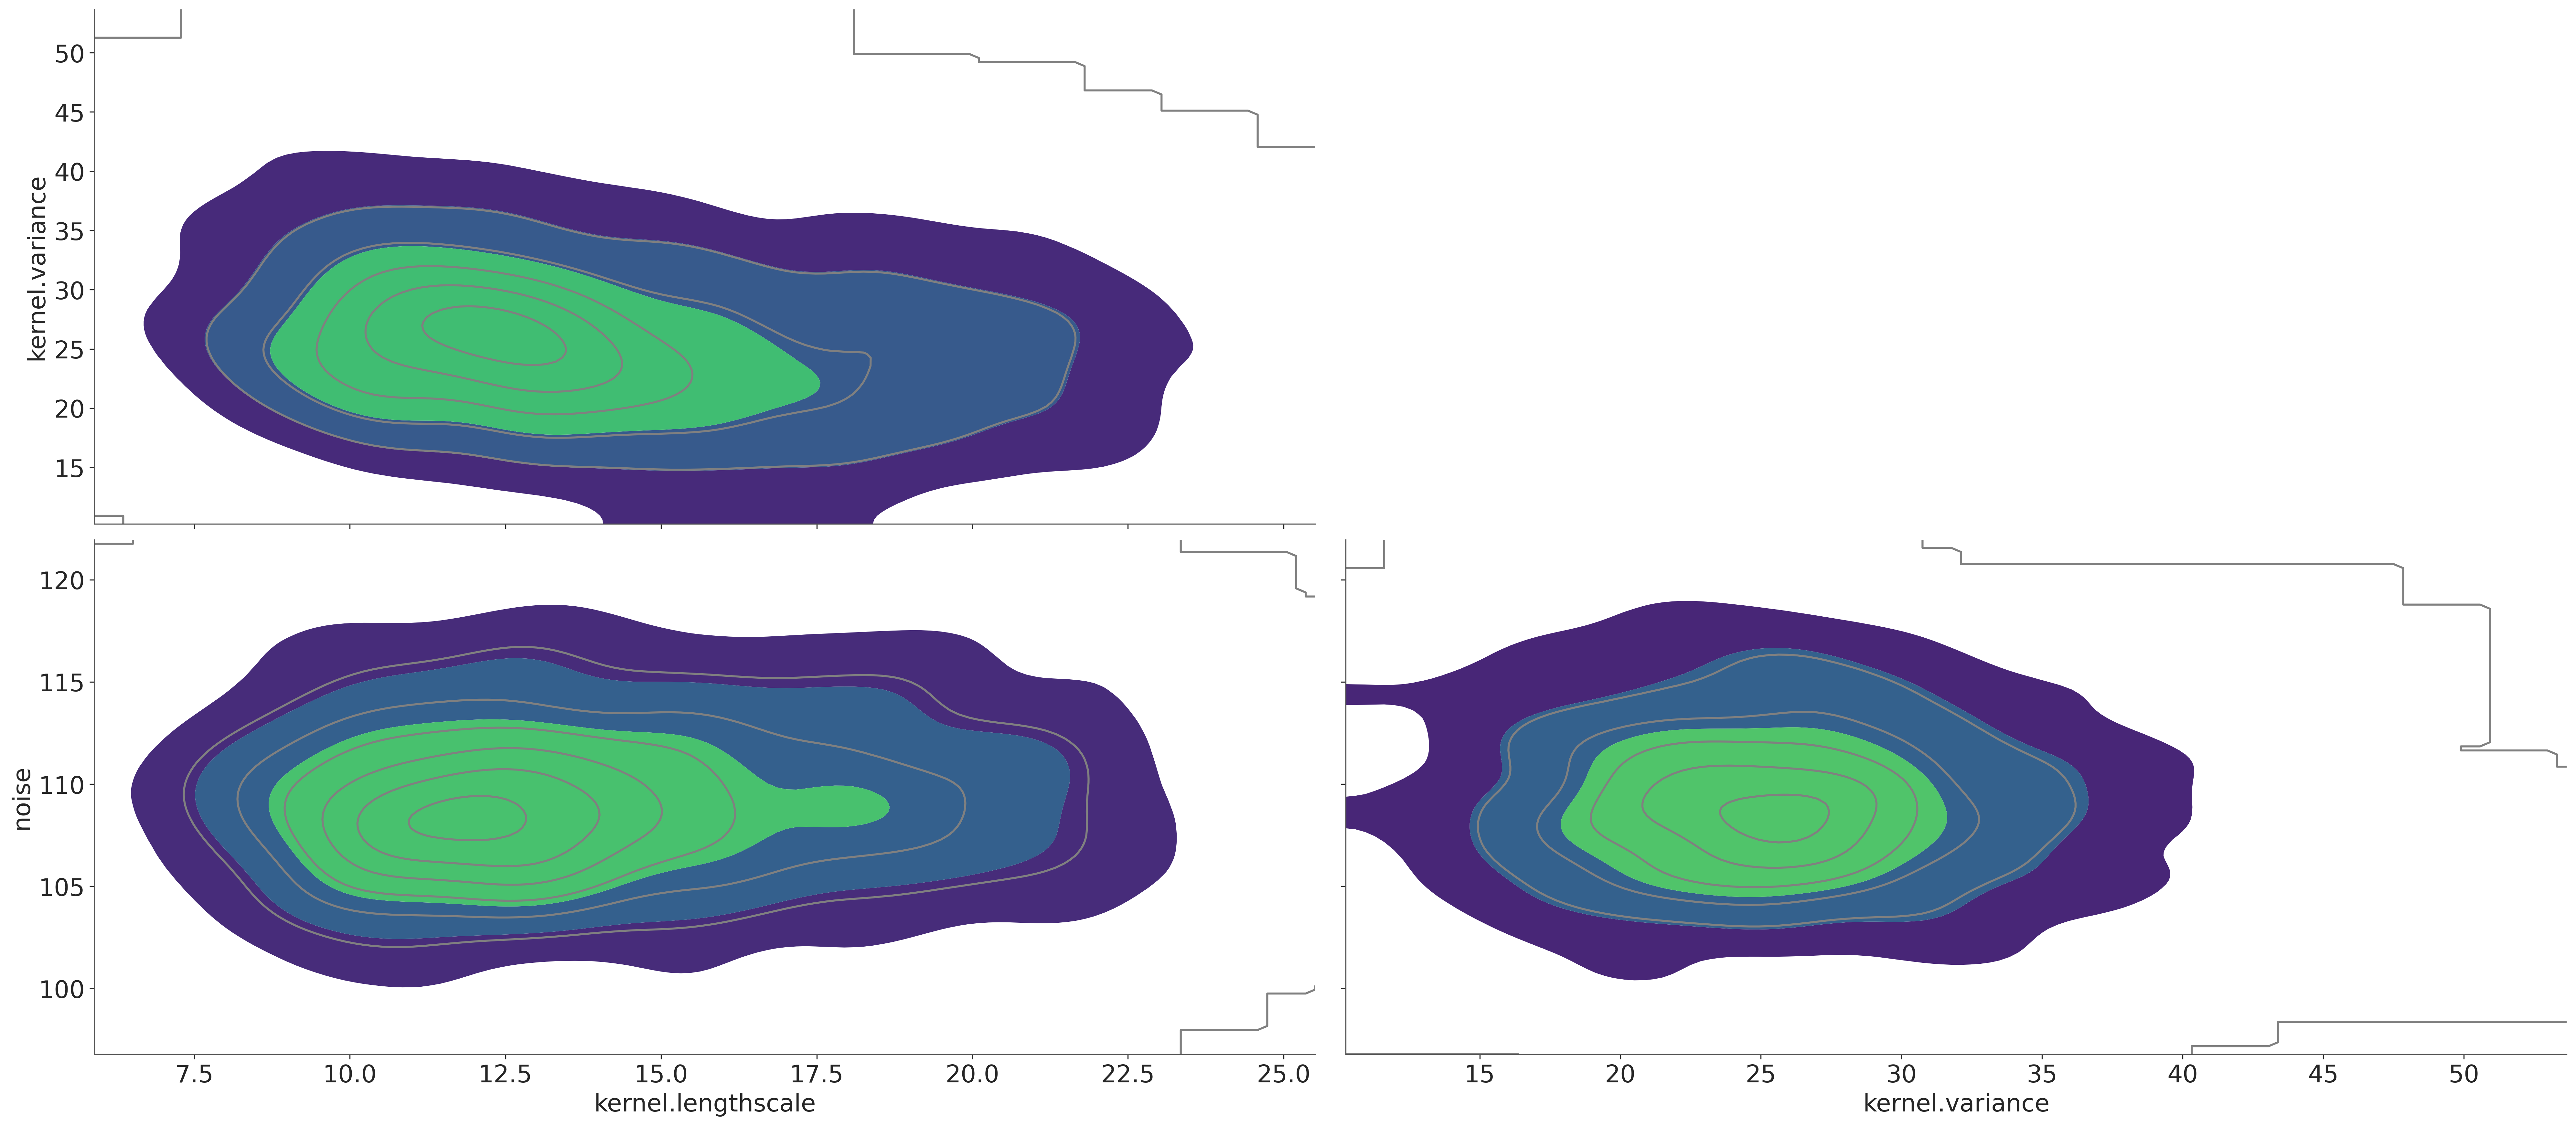

In [23]:
az.plot_pair(pyro_data_acetone,kind='kde',divergences=True,textsize=18)
